# Credit Risk
---

In [1]:
import os
import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.stats
import seaborn.apionly as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, feature_extraction, feature_selection
from sklearn import linear_model, tree, svm, naive_bayes, neural_network, ensemble, metrics
%matplotlib inline
slc = lambda x: [*range(x)] + [*range(-x,0)]

---
## Load Data:
---

In [2]:
!wc -l takehome/*

       29 takehome/README.md
       81 takehome/data_dictionary.txt
     9181 takehome/dv_dev.tsv
     9181 takehome/fico_dev.tsv
     2895 takehome/fico_oot.tsv
  2917987 takehome/trans_dev.tsv
   875277 takehome/trans_oot.tsv
  3814631 total


In [3]:
dv_names = ['cid','label']
dv = pd.read_csv('takehome/dv_dev.tsv', sep = '\t', header = None, names = dv_names)
dv.label = dv.label.astype(int)
dv.iloc[slc(3)]

,cid,label
0,895618698696104428,0
1,-703179405226426567,0
2,8113623744569174532,0
9178,-6008255704770118336,0
9179,-3642939254903063126,0
9180,-355212071407260410,0


In [4]:
fico_names = ['cid','fico']
fico_dev = pd.read_csv('takehome/fico_dev.tsv', sep = '\t', header = None, names = fico_names)
fico_dev.iloc[slc(3)]

,cid,fico
0,895618698696104428,716.0
1,-703179405226426567,772.0
2,8113623744569174532,699.0
9178,-6008255704770118336,663.0
9179,-3642939254903063126,652.0
9180,-355212071407260410,683.0


In [5]:
fico_oot = pd.read_csv('takehome/fico_oot.tsv', sep = '\t', header = None, names = fico_names)
fico_oot.iloc[slc(3)]

,cid,fico
0,3312499378347746550,690.0
1,7179775600150417434,0.0
2,-839832388935343616,693.0
2892,2572739010848748157,661.0
2893,3960804455861603112,609.0
2894,-2632325340169730758,676.0


In [6]:
trans_names = ['cid','tdays2loan','tamt','tcat','ttype']
trans_dev = pd.read_csv('takehome/trans_dev.tsv', sep = '\t', header = None, names = trans_names)
trans_dev['ttype2'] = trans_dev.ttype.str.startswith('cre').astype(int)
trans_dev.ttype2.replace(0, -1, inplace = True)
trans_dev.tamt = trans_dev.tamt * trans_dev.ttype2
trans_dev.drop(['ttype', 'ttype2'], axis = 1, inplace = True)
trans_dev.iloc[slc(3)]

,cid,tdays2loan,tamt,tcat
0,895618698696104428,0,-36.75,Groceries
1,895618698696104428,0,-193.75,Checks
2,895618698696104428,0,-3.90,Gasoline/Fuel
2917984,-355212071407260410,58,-100.00,Transfers
2917985,-355212071407260410,58,15000.00,Transfers
2917986,-355212071407260410,58,-15000.00,Transfers


In [7]:
trans_oot = pd.read_csv('takehome/trans_oot.tsv', sep = '\t', header = None, names = trans_names)
trans_oot['ttype2'] = trans_oot.ttype.str.startswith('cre').astype(int)
trans_oot.ttype2.replace(0, -1, inplace = True)
trans_oot.tamt = trans_oot.tamt * trans_oot.ttype2
trans_oot.drop(['ttype', 'ttype2'], axis = 1, inplace = True)
trans_oot.iloc[slc(3)]

,cid,tdays2loan,tamt,tcat
0,3312499378347746550,0,106.24,Transfers
1,3312499378347746550,0,-35.00,Postage and Shipping
2,3312499378347746550,0,-15.99,Postage and Shipping
875274,-2632325340169730758,57,-100.00,ATM/Cash Withdrawals
875275,-2632325340169730758,57,-24.10,Uncategorized
875276,-2632325340169730758,57,-29.95,Uncategorized


---
## Merge Tweak:
---

In [8]:
print([dv.cid.nunique(), fico_dev.cid.nunique(), trans_dev.cid.nunique()])
print([len(x) for x in (dv, fico_dev, trans_dev)])

[9181, 9181, 9139]
[9181, 9181, 2917987]


In [9]:
d1 = dv.merge(fico_dev, on = 'cid', how = 'left')
d1.iloc[slc(3)]

,cid,label,fico
0,895618698696104428,0,716.0
1,-703179405226426567,0,772.0
2,8113623744569174532,0,699.0
9178,-6008255704770118336,0,663.0
9179,-3642939254903063126,0,652.0
9180,-355212071407260410,0,683.0


In [10]:
d2 = trans_dev.merge(d1, on = 'cid', how = 'left')
d2.iloc[slc(3)]

,cid,tdays2loan,tamt,tcat,label,fico
0,895618698696104428,0,-36.75,Groceries,0,716.0
1,895618698696104428,0,-193.75,Checks,0,716.0
2,895618698696104428,0,-3.90,Gasoline/Fuel,0,716.0
2917984,-355212071407260410,58,-100.00,Transfers,0,683.0
2917985,-355212071407260410,58,15000.00,Transfers,0,683.0
2917986,-355212071407260410,58,-15000.00,Transfers,0,683.0


---
## Pre-modeling Analyis:
---

In [11]:
corrs = d2[['label','fico','tdays2loan','tamt']].corr('spearman')
corrs.style.background_gradient(cmap = 'GnBu')

,label,fico,tdays2loan,tamt
label,1,-0.20399,-0.0019243,0.0140712
fico,-0.20399,1,-0.00139039,-0.0510459
tdays2loan,-0.0019243,-0.00139039,1,-0.00327546
tamt,0.0140712,-0.0510459,-0.00327546,1


In [12]:
print('Eigenvector analysis of the correlation matrix:\n')
print('Eigenvalue \t Sorted Eigenvector Dimensions')
eig_vals, eig_vecs = np.linalg.eig(corrs.as_matrix())
eig_vals_sorted = np.sort(eig_vals)[::-1]
eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()][::-1]
for i in range(len(eig_vals)):
    print(eig_vals_sorted[i], [*corrs.columns[[x[0] for x in sorted([*enumerate(np.abs(eig_vecs_sorted[i]))], key = lambda x: -x[1])]]])

Eigenvector analysis of the correlation matrix:

Eigenvalue 	 Sorted Eigenvector Dimensions
1.21397923721 ['fico', 'tdays2loan', 'tamt', 'label']
1.00104990092 ['tdays2loan', 'fico', 'label', 'tamt']
0.992377067786 ['label', 'tamt', 'fico', 'tdays2loan']
0.792593794081 ['label', 'tamt', 'fico', 'tdays2loan']


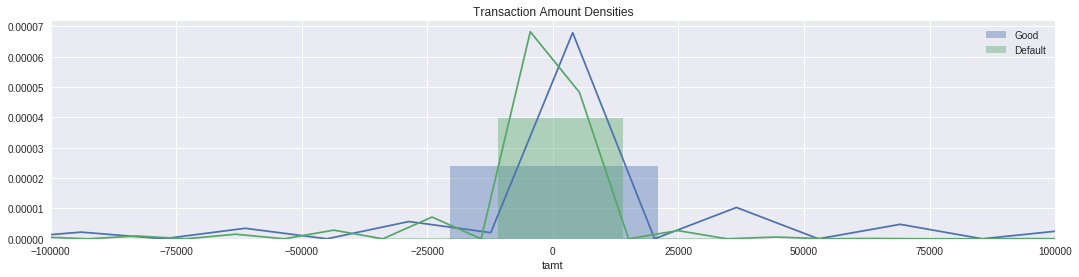

In [13]:
fix, ax = plt.subplots(1, 1, figsize = (18,4))
sns.distplot(d2[d2.label == 0].tamt, label='Good')
sns.distplot(d2[d2.label == 1].tamt, label = 'Default')
plt.title('Transaction Amount Densities')
ax.set_xlim((-10**5, 10**5))
plt.legend();

In [14]:
d1.query('fico > 850') # a very bad outlier.

,cid,label,fico
45,1545585625256343411,1,9002.0


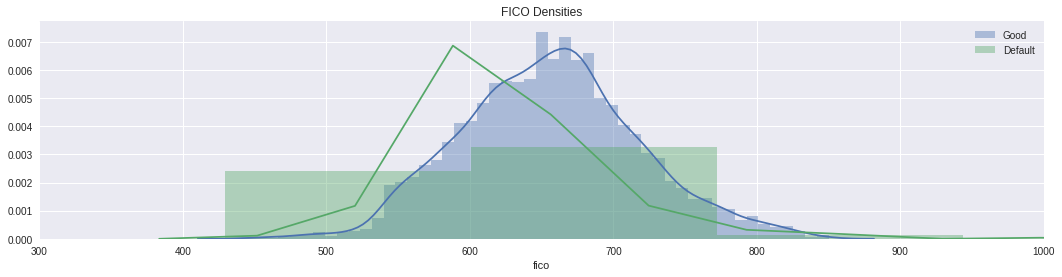

In [15]:
fix, ax = plt.subplots(1, 1, figsize = (18,4))
sns.distplot(d1[d1.label == 0].fico, label='Good')
sns.distplot(d1[d1.label == 1].fico, label = 'Default')
plt.title('FICO Densities')
ax.set_xlim((300, 1000))
plt.legend();

In [16]:
vc1 = d1.label.value_counts().as_matrix()
vc2 = d2.label.value_counts().as_matrix()
rate1 = vc1[0]/vc1.sum()
rate2 = vc2[0]/vc2.sum()
print('\n', vc1, rate1)
print('\n', vc2, rate2)


 [8112 1069] 0.88356388193

 [2603481  314506] 0.892218162727


---
## Baseline Model: logit(label) = b*fico + a
---

In [17]:
md1 = d1[['label','fico']].query('fico < 1000')

In [18]:
X, y = (md1.fico.values.reshape(1, -1).T, md1.label)

In [19]:
binlog1 = linear_model.LogisticRegression(C = 10**9)
binlog1.fit(X, y)
print('Score: ', round(binlog1.score(X, y), 4))
print('Probit Slope:', round(float(binlog1.coef_[0][0]), 4))

Score:  0.8837
Probit Slope: -0.0088


In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 10)
binlog1t = linear_model.LogisticRegression(C = 10**9)
binlog1t.fit(X_train, y_train)
predicted = binlog1t.predict(X_test)
probs = binlog1t.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.699310158571
Accuracy:  0.883877995643
Confusion Matrix:
 [[4057    0]
 [ 533    0]]
             precision    recall  f1-score   support

          0       0.88      1.00      0.94      4057
          1       0.00      0.00      0.00       533

avg / total       0.78      0.88      0.83      4590



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## Logistic Model More Factors:
---

In [21]:
md2 = d2[['label','fico','tamt','tdays2loan']].query('fico < 1000')

In [22]:
X, y = (md2.iloc[:, 1:], md2.label)

In [23]:
binlog2 = linear_model.LogisticRegression(C = 10**9)
binlog2.fit(X, y)
print('Score: ', round(binlog2.score(X, y), 4))
print('Probit Gradient:', binlog2.coef_)

Score:  0.8922
Probit Gradient: [[ -9.88483668e-03  -2.94617471e-07  -1.54563298e-05]]


In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
binlog1t = linear_model.LogisticRegression(C = 10**9)
binlog1t.fit(X_train, y_train)
predicted = binlog1t.predict(X_test)
probs = binlog1t.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.689368853722
Accuracy:  0.892216225553
Confusion Matrix:
 [[1301593       0]
 [ 157252     113]]
             precision    recall  f1-score   support

          0       0.89      1.00      0.94   1301593
          1       1.00      0.00      0.00    157365

avg / total       0.90      0.89      0.84   1458958



---
## Decision Tree Classifiers:
---

In [25]:
X, y = (md2.iloc[:, 1:], md2.label)

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
dtree = tree.DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 34)
dtree.fit(X_train, y_train)
predicted = dtree.predict(X_test)
probs = dtree.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.748430521914
Accuracy:  0.894951054108
Confusion Matrix:
 [[1297966    3627]
 [ 149635    7730]]
             precision    recall  f1-score   support

          0       0.90      1.00      0.94   1301593
          1       0.68      0.05      0.09    157365

avg / total       0.87      0.89      0.85   1458958



In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
dtree = tree.DecisionTreeClassifier(max_depth = 24, min_samples_leaf = 34)
dtree.fit(X_train, y_train)
predicted = dtree.predict(X_test)
probs = dtree.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.79536855407
Accuracy:  0.897917554858
Confusion Matrix:
 [[1284130   17463]
 [ 131471   25894]]
             precision    recall  f1-score   support

          0       0.91      0.99      0.95   1301593
          1       0.60      0.16      0.26    157365

avg / total       0.87      0.90      0.87   1458958



In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
dtree = ensemble.RandomForestClassifier(n_estimators = 20, min_samples_leaf = 34)
dtree.fit(X_train, y_train)
predicted = dtree.predict(X_test)
probs = dtree.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.791693378443
Accuracy:  0.89476393426
Confusion Matrix:
 [[1300773     820]
 [ 152715    4650]]
             precision    recall  f1-score   support

          0       0.89      1.00      0.94   1301593
          1       0.85      0.03      0.06    157365

avg / total       0.89      0.89      0.85   1458958



---
## Support Vector Classifier:
---

In [ ]:
X, y = (preprocessing.scale(md2.iloc[:, 1:]), md2.label)

In [ ]:
assert(False) # SVC takes too long...
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
svc = svm.LinearSVC(class_weight = 'balanced', random_state = 0, n_jobs = os.cpu_count())
svc.fit(X_train, y_train)
predicted = svc.predict(X_test)
probs = svc.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

---
## Stochastic Gradient Classifier:
---

In [29]:
X, y = (md2.iloc[:, 1:], md2.label)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
sgdc = linear_model.SGDClassifier(loss = 'log', random_state = 0)
sgdc.fit(X_train, y_train)
predicted = sgdc.predict(X_test)
probs = sgdc.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


ROC AUC:  0.488131560575
Accuracy:  0.777756453579
Confusion Matrix:
 [[1115899  185694]
 [ 138550   18815]]
             precision    recall  f1-score   support

          0       0.89      0.86      0.87   1301593
          1       0.09      0.12      0.10    157365

avg / total       0.80      0.78      0.79   1458958



---
## Naive Bayes Classifier:
---

In [30]:
X, y = (md2.iloc[:, 1:], md2.label)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
nbm = naive_bayes.GaussianNB()
nbm.fit(X_train, y_train)
predicted = nbm.predict(X_test)
probs = nbm.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.687305194874
Accuracy:  0.89221348387
Confusion Matrix:
 [[1301593       0]
 [ 157256     109]]
             precision    recall  f1-score   support

          0       0.89      1.00      0.94   1301593
          1       1.00      0.00      0.00    157365

avg / total       0.90      0.89      0.84   1458958



---
## Neural Network Classification:
---

In [31]:
X, y = (preprocessing.MinMaxScaler().fit_transform(md2.iloc[:, 1:]), md2.label)

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
mlp = neural_network.MLPClassifier(hidden_layer_sizes = (0,), activation = 'relu', solver = 'adam', random_state = 0)
nbm.fit(X_train, y_train)
predicted = nbm.predict(X_test)
probs = nbm.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.687305263552
Accuracy:  0.89221348387
Confusion Matrix:
 [[1301593       0]
 [ 157256     109]]
             precision    recall  f1-score   support

          0       0.89      1.00      0.94   1301593
          1       1.00      0.00      0.00    157365

avg / total       0.90      0.89      0.84   1458958



---
## Back to Transaction Categories:
---

In [33]:
d2.iloc[:, 1:].pivot_table(index = ['tcat'], columns = ['label'], aggfunc = np.sum).style.background_gradient(cmap = 'GnBu', axis = 1)

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [34]:
marginal = d2[['label','tcat','cid']].groupby(['tcat','label']).cid.count().unstack()
marginal.style.background_gradient(cmap = 'GnBu')

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


label,0,1
tcat,,
ATM/Cash Withdrawals,101374,16737
Advertising,546,59
Automotive Expenses,28986,3728
Business Miscellaneous,17615,2086
Cable/Satellite Services,13402,1581
Charitable Giving,3130,379
Checks,352239,31353
Child/Dependent Expenses,2712,367
Clothing/Shoes,30630,3934


In [ ]:
## Ideas SparseArrays, FeatureHasher, Scala.MLIB...

---
## Out of Sample Prediction:
---

In [ ]:
X_train, y_train = (md2.iloc[:, 1:], md2.label)

In [ ]:
td2 = fico_oot.merge(trans_oot, on = 'cid', how = 'left')
tmd2 = td2[['fico','tamt','tdays2loan']].copy()
tmd2.tamt.fillna(0, inplace = True) # fake data for missing values
tmd2.tdays2loan.fillna(2000, inplace = True)

In [ ]:
tmd2.query('fico > 1000')

In [ ]:
tmd2.head()

In [ ]:
X_test = tmd2

In [ ]:
dtree = tree.DecisionTreeClassifier(max_depth = 24, min_samples_leaf = 34)
dtree.fit(X_train, y_train)
predicted = dtree.predict(X_test)
probs = dtree.predict_proba(X_test)

In [ ]:
assert len(tmd2) == len(predicted)
assert len(tmd2) == len(probs)
print(len(tmd2))

In [ ]:
print(predicted[:10])
print(probs[:10])

In [ ]:
probs[:,1][:20]

In [ ]:
td2['prob'] = pd.Series(probs[:,1])

In [ ]:
td2.rename(columns = {'cid':'account_id'}, inplace = True)

In [ ]:
td2.head()

In [ ]:
td2.groupby('account_id').prob.mean().reset_index()